<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/Bursty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [10]:
import time
import scipy 

## Inhomogeneous burst size

In [11]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%config InlineBackend.figure_format = 'retina'

def gillvec_burst_inhom(k,tvec,tau,bvec,S,nCells,propfun,burstfun):
    n_species = S.shape[1]

    num_t_pts = len(tvec)
    X_mesh = np.zeros((nCells,num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 

    t = np.zeros(nCells,dtype=float)
    tindex = np.zeros(nCells,dtype=int)

    #initialize state: integer unspliced, integer spliced 
    X = np.zeros((nCells,n_species),dtype=int)

    #initialize list of cells that are being simulated
    activecells = np.ones(nCells,dtype=bool)
    while any(activecells):
        mu = np.zeros(nCells,dtype=int)
        n_active_cells = np.sum(activecells)        
        (dt,mu_upd) = rxn_calculator(X[activecells,:],k,propfun)

        t[activecells] += dt
        mu[activecells] = mu_upd

        update = np.zeros(nCells,dtype=bool)
        update[activecells] = t[activecells] > tvec[tindex[activecells]]
        while np.any(update):
            X_mesh[update,tindex[update],:] = X[update]
            tindex += update
            ended_in_update = (tindex==num_t_pts) #less efficient
            if np.any(ended_in_update):
                activecells[ended_in_update] = False
                mu[ended_in_update] = 0
                if not np.any(activecells):
                    print('end simulation')
                    break
            update = np.zeros(nCells,dtype=bool)
            update[activecells] = t[activecells]>tvec[tindex[activecells]]
        
        burst = (mu == 1) & activecells
        bs = burstfun(tau,bvec,t[burst])
        # print(bs.shape)
        bsrand = (np.random.geometric(1/(1+bs))-1 )
        # print(bsrand.shape)
        X[burst] += bsrand[:,None]
        X[~burst] += S[mu[~burst]-1]
    return X_mesh

def rxn_calculator(X,k,propfun):
    nRxn = len(k)
    nCells = X.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
 ################################
    a = propfun(a, k, X)
#################################
    a0 = np.sum(a,1)
    dt = np.log(1./np.random.rand(nCells)) / a0
    r2ao = a0 * np.random.rand(nCells)
    mu = np.sum(np.matlib.repmat(r2ao,nRxn+1,1).T >= np.cumsum(np.matlib.hstack((np.zeros((nCells,1)),a)),1) ,1)
    return (dt,mu)

def propfun_bursty(a,k,x):
    k1,g = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    a[0] = k1
    a[1] = g * x
    #######
    a = a.T
    return a


In [12]:
def piecewise_constant(tau,kvec,t):
    # print(type(t))
    # print(t.shape)
    if (isinstance(t,np.ndarray)):
        k = np.zeros(t.shape)
        for i in range(len(t)):
            lowlim = np.where(tau<=t[i])[0][-1]
            k[i] = kvec[lowlim]
        # print(k)//
    elif (isinstance(t,float) or isinstance(t,complex)):
        lowlim = np.where(tau<=t)[0][-1]
        k = kvec[lowlim]
    else:
        print(type(t))
        raise ValueError
    return k

In [13]:
S = np.asarray([[100],[-1]],dtype=int)
k = [1.2,0.2]
# bs = 5
nCells = 10000
T=6
# tvec = np.sort(np.random.rand(nCells))*T
tvec = np.sort(np.random.rand(nCells))*T
# tvec = np.linspace(0,T,1000)
propfun = propfun_bursty

bvec = np.asarray([5,15,3]).astype(float)
tau = np.asarray([0,2,4]).astype(float)

burstfun = piecewise_constant

In [14]:
X = gillvec_burst_inhom(k,tvec,tau,bvec,S,nCells,propfun,burstfun)

end simulation


In [ ]:
mx = X.max()+10
bins = np.arange(mx)-0.5
_=plt.hist(X[:,-1,:],bins=bins,density=True,facecolor='lightgray')

x = np.arange(mx)
y = scipy.stats.nbinom.pmf(x,k[0]/k[1],1/(1+bvec[-1]))
plt.plot(x,y,'r.-',label='SS')


x = np.arange(mx)
y = eval_model_inh_burst(tau,k[0],k[1],bvec,burstfun,T,mx)
plt.plot(x,y,'g.--',label='Transient inhomogeneous')

plt.legend()
plt.xlim([-1,100])

## Inhomogeneous frequency bursty

In [23]:
from numpy import matlib
def gillvec_inh(tau,kvec,beta,tvec,S,bs,nCells):
    n_species = S.shape[1]

    num_t_pts = len(tvec)
    X_mesh = np.zeros((nCells,num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 

    t = np.zeros(nCells,dtype=float)
    tindex = np.zeros(nCells,dtype=int)

    X = np.zeros((nCells,n_species),dtype=int)

    activecells = np.ones(nCells,dtype=bool)
    while any(activecells):
        mu = np.zeros(nCells,dtype=int)
        n_active_cells = np.sum(activecells)        
        (dt,mu_upd) = rxn_calculator_inh(X[activecells,:],t,tau,kvec,beta)

        t[activecells] += dt
        mu[activecells] = mu_upd

        update = np.zeros(nCells,dtype=bool)
        update[activecells] = t[activecells] > tvec[tindex[activecells]]
        while np.any(update):
            X_mesh[update,tindex[update],:] = X[update]
            tindex += update
            ended_in_update = (tindex==num_t_pts) #less efficient
            if np.any(ended_in_update):
                activecells[ended_in_update] = False
                mu[ended_in_update] = 0
                if not np.any(activecells):
                    print('end simulation')
                    break
            update = np.zeros(nCells,dtype=bool)
            update[activecells] = t[activecells]>tvec[tindex[activecells]]
        
        burst = (mu == 1) & activecells
        # X[activecells] += S[mu[activecells]-1]

        X[burst] += (np.random.geometric(1/(1+bs),size=(burst.sum(),1))-1 )
        X[~burst] += S[mu[~burst]-1]
        # print(t.mean().round(2),end=' ')
    return X_mesh

def rxn_calculator_inh(X,t,tau,kvec,beta):
    nRxn = len(k)
    nCells = X.shape[0]
    a,dt = propfun_bursty_inh(X,t,tau,kvec,beta)
    a0 = np.sum(a,1)
    # dt = np.log(1./np.random.rand(nCells)) / a0
    r2ao = a0 * np.random.rand(nCells)
    mu = np.sum(matlib.repmat(r2ao,nRxn+1,1).T >= np.cumsum(np.matlib.hstack((np.zeros((nCells,1)),a)),1) ,1)
    return (dt,mu)
 
def propfun_bursty_inh(x,t,tau,kvec,beta):
    nRxn = len(k)
    nCells = x.shape[0]
    Lambda = -np.log(np.random.rand(nCells))
    a = np.zeros((nCells,nRxn),dtype=float)
    dt = np.zeros(nCells)
    
    N = len(tau)
    # print(tau)
    for i in range(nCells):
        if t[i]>=tau[-1]:
            a1 = kvec[-1]
            a2 = beta * x[i]
            a_ = a1 + a2
            dt[i] = Lambda[i]/a_
            a[i,0] = a1*dt[i]
            a[i,1] = a2*dt[i]
        else:
            # print(t[i])
            L = np.where(tau>t[i])[0][0]
            # print(L)
            # raise ValueError
            tr = t[i]
            a1 = 0
            a2 = 0
            a_ = a1 + a2
            while L < N:
                # print(L)
                a1_ = (tau[L] - tr) * kvec[L-1]
                a2_ = (tau[L] - tr) * beta * x[i]
                a__ = a1_ + a2_
                if a__ + a_ > Lambda[i]:
                    dt[i] = tr - t[i] + (tau[L] - tr)*(Lambda[i] - a_)/a__
                    a[i,1] = beta * x[i] * dt[i]
                    a[i,0] = Lambda[i] - a[i,1]
                    break
                else:
                    tr = tau[L]
                    a1 += a1_
                    a2 += a2_
                    a_ += a__
                    L += 1
            if L>=N:
                a1_ = kvec[-1]
                a2_ = beta * x[i]
                a__ = a1_ + a2_
                dt[i] = tr - t[i] + (Lambda[i] - a_)/a__

                a[i,1] = beta * x[i] * dt[i]
                a[i,0] = Lambda[i] - a[i,1]
    return a,dt


In [24]:
from math import log, exp

In [25]:
def Gillespie_bursty_1D_single(ts, te, x0, kvec, tau, beta, bs, random_seed = None):
    """
    Gillespie algorithm for the system:
        null -> x: production rate CIR process
        x -> null: degradation rate gamma
     
    Parameters
    ----------
    ts : float
        Start time 
    te : float
        End time 
    x0 : float
        Initial value
    beta: float
        Degradation rate 
    bs : floats
        mean burst size
    random_seed : int
        set numpy.random.seed
        
    Returns
    -------
    T : ndarray
        Time points  
    X : ndarray
        The value of x at time points in T

    """
    # np.random.seed is global
    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    #np.random.seed()    
    t=ts
    x=x0 #system state
    T=[]
    X=[]

    while t<te:
        T.append(t)
        X.append(x)
        
        rv=np.random.uniform(0,1,2) 
        
        # calculate propensity functions
        state = np.where(np.array(tau)<=t)[0][-1]
        k = kvec[state]
        a_cumsum=np.array([k, beta*x+k])
        tau=-log(rv[0])/a_cumsum[-1]
            
        t=t+tau 
        
        a_normalized=a_cumsum/a_cumsum[-1]
        if rv[1]<= a_normalized[0]:
            idx=0
            x=x+np.random.geometric(1/(bs+1))-1
        else:
            idx=1
            x=x-1

    T.append(t)
    X.append(x)

    return np.array(T), np.array(X)


In [26]:
def Gillespie_bursty_2D(ts, te, x0, kvec, tau, beta, gamma, bs, random_seed = None):
    """
    Gillespie algorithm for the system:
        null -> X1: production rate
        X1 -> X2 : beta
        X2 -> null: degradation rate gamma
     
    Parameters
    ----------
    ts : float
        Start time 
    te : float
        End time 
    x0 : 1D array
        Initial value
    beta : float
        Splicing rate
    gamma: float
        Degradation rate 
    bs : floats
        mean burst size
    random_seed : int
        set numpy.random.seed
        
    Returns
    -------
    T : ndarray
        Time points  
    X : ndarray
        The value of x at time points in T

    """
    # np.random.seed is global
    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    #np.random.seed()    
    t=ts
    x=x0 #system state
    T=[]
    X=[]

    while t<te:
        T.append(t)
        X.append(x)
        
        rv=np.random.uniform(0,1,2) 
        
        # calculate propensity functions
        state = np.where(np.array(tau)<=t)[0][-1]
        k = kvec[state]
        a_cumsum=np.array([k, beta*x[0]+k, gamma*x[1]+beta*x[0]+k])
        tau=-log(rv[0])/a_cumsum[-1]
            
        t=t+tau 
        
        a_normalized=a_cumsum/a_cumsum[-1]
        if rv[1]<= a_normalized[0]:
            x[0]=x[0]+np.random.geometric(1/(bs+1))-1
        elif rv[1]<= a_normalized[1]:
            x=x+[0,-1,1]
        else:
            x=x+[0,0,-1]

    T.append(t)
    X.append(x)

    return np.array(T), np.array(X)

In [27]:
def Gillespie_bursty_1D(ncell, tvec, x0, kvec, tau, beta, bs, random_seed = None):
    m = len(tvec)
    X = np.zeros((ncell,m))
    for i in range(ncell):
        T, x = Gillespie_bursty_1D_single(tvec[0], tvec[-1], x0, kvec, tau, beta, bs, random_seed)
        k=0
        for j in range(m):
            while T[k]<=tvec[j]:
                k=k+1
            X[i,j]=x[k-1]
    return X

# Test

## Gillespie

In [3]:
k = [10,10]
bs = 1
T=10

beta = 1
gamma = 2
S = np.asarray([[100],[-1]],dtype=int)

kvec = np.asarray(k)
tau = np.asarray([0,0.5])
t = np.linspace(0,T,100)

nCells = 10000

In [ ]:
%time X = gillvec_inh(tau,kvec,beta,t,S,bs,nCells)

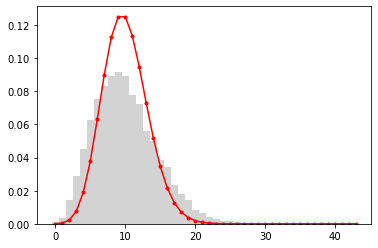

In [136]:
mx = X.max()
bins = np.arange(mx)-0.5
_=plt.hist(X[:,-1,:],bins=bins,density=True,facecolor='lightgray')
x = np.arange(mx)
y = scipy.stats.poisson.pmf(x,k[-1]/beta);
plt.plot(x,y,'r.-',label='SS');

In [7]:
%time X_ = Gillespie_bursty_1D(ncell=10000, tvec=t, x0=0, kvec=k, tau=[0,t[-1]], beta=beta, bs=1, random_seed = None)

NameError: name 'Gillespie_bursty_1D' is not defined

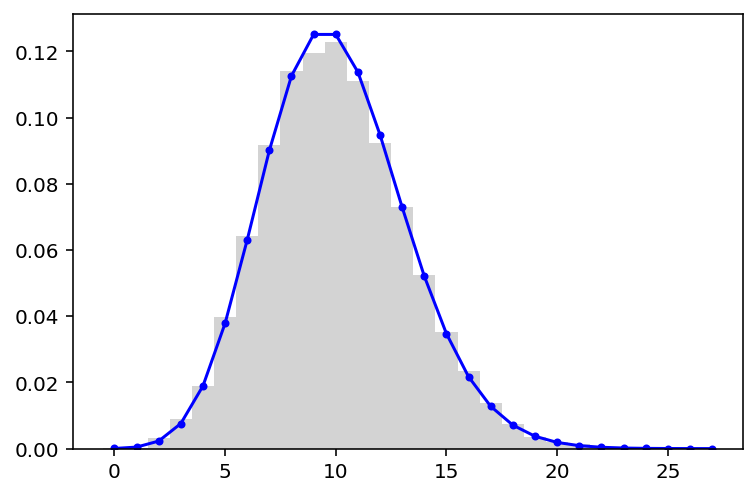

In [20]:
mx = X_.max()
bins = np.arange(mx)-0.5
plt.hist(X_[:,-1],bins=bins,density=True,facecolor='lightgray');
x = np.arange(mx)
y = scipy.stats.poisson.pmf(x,k[-1]/beta);
plt.plot(x,y,'b.-',label='poi');

In [4]:
# -*- coding: utf-8 -*-

# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import poisson, nbinom
import matplotlib.pyplot as plt

def get_P(theta, t, tau, mx):
    # theta = a_1,..., b, u0, s0, beta, gamma
    K = len(theta)-5
    kvec = theta[0:K]
    bvec = theta[K:-4]
    u0 = theta[-4]
    s0 = theta[-3]
    gamma = theta[-1]
    beta = theta[-2]
    
    # Get generating function argument u
    us = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        us.append(u_)
    u = np.meshgrid(*[u_ for u_ in us], indexing='ij')
    for i in range(len(mx)):
        u[i] = u[i].flatten()
    
    # Get generating function
    # M(u)=1/(1 - bu)
    # phi = int_0^t k*bU/(1-bU) + phi_0
    # q = bU 
    
    def get_b(t,tau,bvec):
        return 1
    
    def get_k(t,tau,kvec):
        return kvec[0]
    
    c0 = (u[0]) - (beta/(beta - gamma))*(u[1])       #  coef of e^{-beta s}
    c1 = (beta/(beta - gamma))*(u[1])   # coef of e^{-gamma s}

    t_array = t
    k_array=get_k(t,tau,kvec)
    b_array=get_b(t,tau,bvec)
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/np.min(k_array), 1/beta, 1/gamma])*min_fudge
    t_max = t[-1]
    num_tsteps = len(t)
    
    q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    U0 = c0*np.exp(-beta*t_array) 
    U1 = b_array*c1*np.exp(-gamma*t_array) 
    U = U0 + U1               
    q = b_array*U
    integrand = k_array*q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
                     
    phi_0 = 0
    phi = integral + phi_0   
    gf = np.exp(phi)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    P = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    P = np.abs(P)/np.sum(np.abs(P))             # Normalize
    return P


def neglogL_bursty(theta, x, weight,t,tau):
    """
    calculte negative log likelihood for n data points of one gene
    theta: length K+5: a_1, ..., a_K, u0, s0, beta, gamma, b
    x: n*2 expression of one gene
    weight: n*m
    t: len m
    tau: len K+1
    return a scaler
    """

    P=get_P  # P: m*mx[0]*mx[1]
    L=P[:,:,x] #n
    logL = np.sum(weight * np.log(L))
    return -logL

In [5]:
P = get_P(theta=[k[0],1, 0, 0, beta, gamma], t=t, tau=tau, mx=[100,100])

In [6]:
mx = X_.max()
bins = np.arange(mx)-0.5
plt.hist(X_[:,-1],bins=bins,density=True,facecolor='lightgray');
x = np.arange(mx)
y = scipy.stats.poisson.pmf(x,k[-1]/beta);
plt.plot(x,y,'b.-',label='poi');
plt.plot(P.sum(axis=1),'r.-',label='poi');

NameError: name 'X_' is not defined